In [ ]:
import sys 
!activate myenv
!{sys.executable} -m pip uninstall tensorflow
!{sys.executable} -m pip install tensorflow=2.18.0 -i https://pypi.tuna.tsinghua.edu.cn/simple
import tensorflow as tf

# 😁training model

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pprint
print(tf.__version__)
# Add this configuration before your plotting code
plt.rcParams['font.sans-serif'] = ['SimHei']  # Use SimHei font for Chinese characters
plt.rcParams['axes.unicode_minus'] = False    # Fix minus sign display issue

2.19.0


In [8]:
class UWBDataset:
    def __init__(self, features, labels, seq_length=10, batch_size=32):
        self.features = features
        self.labels = labels
        self.seq_length = seq_length
        self.batch_size = batch_size
    
    # create RNN dataset
    def create_dataset(self):
        dataset = []
        labels = []
        for i in range(len(self.features) - self.seq_length + 1):
            dataset.append(self.features[i:i + self.seq_length])
            labels.append(self.labels[i + self.seq_length - 1])
            
        dataset = tf.convert_to_tensor(dataset, dtype=tf.float32)
        labels = tf.convert_to_tensor(labels, dtype=tf.int32)
        
        tf_dataset = tf.data.Dataset.from_tensor_slices((dataset, labels))
        tf_dataset = tf_dataset.shuffle(buffer_size=1000).batch(self.batch_size)
        
        return tf_dataset

In [9]:
class UWBDataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        
    def load_and_process(self, seq_length=10, batch_size=32, test_size=0.2):
        df = pd.read_csv(self.file_path)
        df.columns = [col.strip().replace('\ufeff', '') for col in df.columns]
        features = df.drop(['phone'], axis=1).values
        labels = df['phone'].values

        unique_labels = np.unique(labels)
        label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
        labels = np.array([label_mapping[label] for label in labels])
        
        # 标准化特征
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        
        X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=test_size, random_state=42)
        
        # 创建数据集
        train_dataset = UWBDataset(X_train, y_train, seq_length, batch_size)
        test_dataset = UWBDataset(X_test, y_test, seq_length, batch_size)
        
        return (train_dataset.create_dataset(), 
                test_dataset.create_dataset(), 
                features.shape[1], 
                len(np.unique(labels)))

In [ ]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
        
    def build(self, input_shape):
        # 增加特征维度的注意力权重
        self.W_feature = self.add_weight(name='feature_weight',
                               shape=(input_shape[-1], input_shape[-1]),
                               initializer='random_normal',
                               trainable=True)
        self.W_time = self.add_weight(name='time_weight',
                               shape=(input_shape[-1], 1),
                               initializer='random_normal',
                               trainable=True)
        self.b = self.add_weight(name='bias',
                               shape=(input_shape[1], 1),
                               initializer='zeros',
                               trainable=True)
    # 对RNN进行时间维度的注意力计算不一定会有更好的效果，但对不偏向最近时间步长的场景有一定的帮助
    def call(self, inputs):
        # 需要reshape输入以适应Dense层
        # inputs shape:(batch_size, 10, 64)
        batch_size = tf.shape(inputs)[0]
        
        # reshape: (batch_size * 10, 64)
        reshaped_inputs = tf.reshape(inputs, (-1, inputs.shape[-1]))
        
        # Dense层实现特征注意力
        # (batch_size * 10, 64) -> (batch_size * 10, 64)
        feature_attention = tf.keras.layers.Dense(64)(reshaped_inputs)
        # (batch_size * 10, 64) -> (batch_size, 10, 64)
        feature_attention = tf.reshape(feature_attention, (batch_size, -1, 64))
        
        # Dense层实现时间注意力
        # (batch_size, 10, 64) -> (batch_size, 10, 1)
        time_scores = tf.keras.layers.Dense(1, activation='tanh')(feature_attention)
        # (batch_size, 10, 1), softmax使权重和为1
        time_weights = tf.keras.backend.softmax(time_scores, axis=1)
        
        # (batch_size, 10, 64) * (batch_size, 10, 1) -> (batch_size, 10, 64)
        return inputs * time_weights

In [11]:
class UWBModel:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self._create_model()
        
    def _create_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.GRU(64, input_shape=self.input_shape, return_sequences=True),
            AttentionLayer(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.GRU(32),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        print(model.summary())
        return model
    
    def train(self, train_dataset, test_dataset, epochs=50):
        class_weights = {0:1.0, 1:1.0}
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
        
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            validation_data=test_dataset,
            callbacks=[early_stopping],
            class_weight=class_weights

        )
        return history
    
    def evaluate(self, test_dataset):
        return self.model.evaluate(test_dataset)

    def predict(self, input_data):
        # Ensure input has correct shape
        input_data = np.array(input_data)
        if input_data.shape != self.input_shape:
            input_data = input_data.reshape(1, *self.input_shape)
        
        # Make prediction
        predictions = self.model.predict(input_data, verbose=0)
        return predictions
    
    
    def plot_history(self, history):
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='训练损失')
        plt.plot(history.history['val_loss'], label='验证损失')
        plt.title('模型损失')
        plt.xlabel('Epoch')
        plt.ylabel('损失')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='训练准确率')
        plt.plot(history.history['val_accuracy'], label='验证准确率')
        plt.title('模型准确率')
        plt.xlabel('Epoch')
        plt.ylabel('准确率')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

d:\ISoftware\anaconda\router\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10, 64)         │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 10, 64)         │            74 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,444 (95.48 KB)

 Trainable params: 24,444 (95.48 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8214 - loss: 0.4690 - val_accuracy: 0.9584 - val_loss: 0.1167
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9603 - loss: 0.1229 - val_accuracy: 0.9616 - val_loss: 0.1064
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9643 - loss: 0.1153 - val_accuracy: 0.9684 - val_loss: 0.0950
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9681 - loss: 0.1001 - val_accuracy: 0.9668 - val_loss: 0.0915
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9713 - loss: 0.0914 - val_accuracy: 0.9679 - val_loss: 0.0923
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9690 - loss: 0.0893 - val_accuracy: 0.9705 - val_loss: 0.0785
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9697 - loss: 0.0854 - val_accuracy: 0.9710 - val_loss: 0.0797
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9725 - loss: 0.0801 - val_accurac

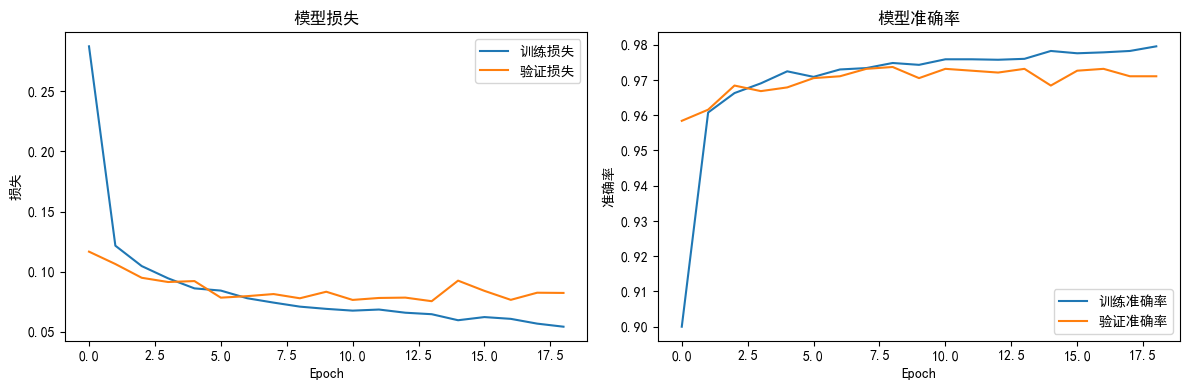

In [13]:
if __name__ == "__main__":
    processor = UWBDataProcessor('UwbCOM_Log_2025-03-03-14-14-37.csv')
    train_dataset, test_dataset, num_features, num_classes = processor.load_and_process()
    # print(f'num_features={num_features} num_classes={num_classes}')

    # for x, y in train_dataset.take(1):
    #     print("训练数据形状:", x.shape)
    #     print("标签形状:", y.shape)
    
    # print(f'特征数量={num_features} 类别数量={num_classes}')
    
    uwb_model = UWBModel((10, num_features), num_classes)
    history = uwb_model.train(train_dataset, test_dataset)
    test_loss, test_accuracy = uwb_model.evaluate(test_dataset)
    print(f'\n测试准确率: {test_accuracy:.4f}')
    
    uwb_model.plot_history(history)

In [ ]:
import os 
save_path = 'phone_scence_model.keras'
uwb_model.model.save(save_path)
model_size = os.path.getsize(save_path) / (1024 * 1024)  # Convert bytes to MB
print(f"模型大小: {model_size:.2f} MB")


# 😎Saved model

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 
print(tf.__version__)

In [ ]:
uwb_model = tf.keras.models.load_model('phone_scence_model.keras')
test_df = pd.read_csv('non_call_1.csv')
test_df.columns = [col.strip().replace('\ufeff', '') for col in test_df.columns]

features = test_df.values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

seq_length = 10
sequences = []
for i in range(len(features_scaled) - seq_length + 1):
    sequences.append(features_scaled[i:i + seq_length])
sequences = np.array(sequences)

predictions = uwb_model.predict(sequences, verbose=0)

for i,prob in enumerate(predictions):
    if prob[1] < 0.5 and prob[1] > prob[0]:
        print(f'set phone to non-phone : {predictions[i]}')
        predictions[i][1] = 0      

predicted_classes = np.argmax(predictions, axis=1)
print(f'predicted_classes:\n{predicted_classes}')

In [ ]:
# 将Y值映射到0-1区间
y_min, y_max = test_df['y'].min(), test_df['y'].max()
y_normalized = (test_df['y'] - y_min) / (y_max - y_min)

plt.figure(figsize=(15, 6))
plt.plot(predicted_classes, 'b-', linewidth=1, label='预测值')
plt.plot(y_normalized, 'g-', linewidth=1, alpha=0.5, label='实际值(归一化)')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
plt.fill_between(range(len(predicted_classes)), predicted_classes, alpha=0.2)
plt.yticks([0, 1], ['非打电话', '打电话'])
plt.title('预测状态与实际值对比')
plt.xlabel('序列索引')
plt.ylabel('状态')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
y_min, y_max = test_df['y'].min(), test_df['y'].max()
y_normalized = (test_df['y'] - y_min) / (y_max - y_min)

# 统计预测值中打电话和非打电话的数量
predicted_phone = sum(predicted_classes > 0.5)
predicted_no_phone = sum(predicted_classes <= 0.5)

plt.figure(figsize=(15, 6))
plt.plot(predicted_classes, 'b-', linewidth=1, label=f'预测值(打电话:{predicted_phone},非打电话:{predicted_no_phone})')
plt.plot(y_normalized, 'g-', linewidth=1, alpha=0.5, label=f'y值')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
plt.fill_between(range(len(predicted_classes)), predicted_classes, alpha=0.2)
plt.yticks([0, 1], ['非打电话', '打电话'])
plt.title('预测状态与实际值对比')
plt.xlabel('序列索引')
plt.ylabel('状态')
plt.grid(True)
plt.legend()
plt.show()